In [ ]:
#Set up and Read the data
import pandas as pd
import sqlite3

# read csv file
df_Fact = pd.read_csv('data.csv')

In [ ]:
df_Fact

,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
74538,542433,22531,MAGIC DRAWING SLATE CIRCUS PARADE,96,1/28/2011 10:45,0.42,12726.0,France
74539,542433,21086,SET/6 RED SPOTTY PAPER CUPS,12,1/28/2011 10:45,0.65,12726.0,France
74540,542433,21094,SET/6 RED SPOTTY PAPER PLATES,24,1/28/2011 10:45,0.85,12726.0,France
74541,542433,21080,SET/20 RED RETROSPOT PAPER NAPKINS,12,1/28/2011 10:45,0.85,12726.0,France


In [ ]:
# connect to database
conn = sqlite3.connect("RFMdb")
cur = conn.cursor()

In [ ]:
# load CRM data into the RFMdb database
df_Fact.to_sql("data", conn)

74543

In [ ]:
# CHECK IF DATA INSERTED INTO data/RFMdb
df_Fact = pd.read_sql('SELECT * FROM data', conn)
df_Fact

,index,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
74538,74538,542433,22531,MAGIC DRAWING SLATE CIRCUS PARADE,96,1/28/2011 10:45,0.42,12726.0,France
74539,74539,542433,21086,SET/6 RED SPOTTY PAPER CUPS,12,1/28/2011 10:45,0.65,12726.0,France
74540,74540,542433,21094,SET/6 RED SPOTTY PAPER PLATES,24,1/28/2011 10:45,0.85,12726.0,France
74541,74541,542433,21080,SET/20 RED RETROSPOT PAPER NAPKINS,12,1/28/2011 10:45,0.85,12726.0,France


In [ ]:

cleandata= pd.read_sql(''' SELECT customerid,
                   MAX(receiptdate) AS last_order_date,
                   COUNT(*) AS count_order,
                   SUM(unitprice*quantity) AS totalprice
                   FROM data
                   WHERE receiptno NOT LIKE '%C%'
                   AND customerid IS NOT NULL
                   AND unitprice != 0
                   GROUP BY customerid ''', conn)

In [ ]:
cleandata

,CustomerID,last_order_date,count_order,totalprice
0,12346.0,1/18/2011 10:01,1,77183.60
1,12347.0,12/07/2010 14:57,60,1187.18
2,12348.0,12/16/2010 19:09,23,1120.24
3,12356.0,1/18/2011 9:50,36,2271.62
4,12359.0,01/12/2011 12:43,16,547.50
...,...,...,...,...
1259,18245.0,12/19/2010 14:58,27,365.73
1260,18259.0,12/08/2010 13:38,7,376.30
1261,18260.0,12/16/2010 18:23,37,787.77
1262,18269.0,12/08/2010 13:53,7,168.60


In [ ]:
# Write clean CRM data into the database
cleandata.to_sql("cleandata", conn)

1264

In [ ]:
#clean the data and calculate rfm values
df_Fact = pd.read_sql(''' SELECT customerid, rfm_recency, rfm_frequency, rfm_monetary, rfm_recency*100 + rfm_frequency*10 + rfm_monetary AS rfm_combined
    FROM
     ( SELECT customerid,
             NTILE(4) OVER (ORDER BY last_order_date) AS rfm_recency,
             NTILE(4) OVER (ORDER BY count_order) AS rfm_frequency,
             NTILE(4) OVER (ORDER BY totalprice) AS rfm_monetary
      FROM
            cleandata
            )
 ''', conn)



In [ ]:
df_Fact

,customerid,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined
0,13313.0,1,2,2,122
1,16875.0,1,3,3,133
2,16282.0,1,2,1,121
3,12957.0,1,3,3,133
4,14462.0,1,1,1,111
...,...,...,...,...,...
1259,15856.0,4,4,4,444
1260,12748.0,4,4,4,444
1261,18116.0,4,4,3,443
1262,15562.0,4,1,1,411


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def rfm_level(df_Fact):
    if ((df_Fact['rfm_recency'] >= 4) and (df_Fact['rfm_frequency'] >= 4)
        and (df_Fact['rfm_monetary'] >= 4)):
        return 'Best Customers'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 3)
          and (df_Fact['rfm_monetary'] >= 3)):
        return 'Loyal'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Potential Loyalist'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 1)):
        return 'Promising'
    elif ((df_Fact['rfm_recency'] >= 2) and (df_Fact['rfm_frequency'] >= 2)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Customers Needing Attention'
    elif ((df_Fact['rfm_recency'] >= 1) and (df_Fact['rfm_frequency'] >= 2)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'At Risk'
    elif ((df_Fact['rfm_recency'] >= 1) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Hibernating'
    else:
        return 'Lost'

#Create a new variable rfm_level

df_Fact['rfm_level'] = df_Fact.apply(rfm_level, axis=1)

df_Fact


,customerid,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,13313.0,1,2,2,122,At Risk
1,16875.0,1,3,3,133,At Risk
2,16282.0,1,2,1,121,Lost
3,12957.0,1,3,3,133,At Risk
4,14462.0,1,1,1,111,Lost
...,...,...,...,...,...,...
1259,15856.0,4,4,4,444,Best Customers
1260,12748.0,4,4,4,444,Best Customers
1261,18116.0,4,4,3,443,Loyal
1262,15562.0,4,1,1,411,Promising


In [ ]:
# Calculate total customers in each segment
rfm_agg = df_Fact.groupby('rfm_level').agg({'customerid':'count'})
print(rfm_agg)


                             customerid
rfm_level                              
At Risk                             176
Best Customers                       78
Customers Needing Attention         188
Hibernating                          73
Lost                                195
Loyal                               213
Potential Loyalist                  220
Promising                           121


In [ ]:
pip install squarify

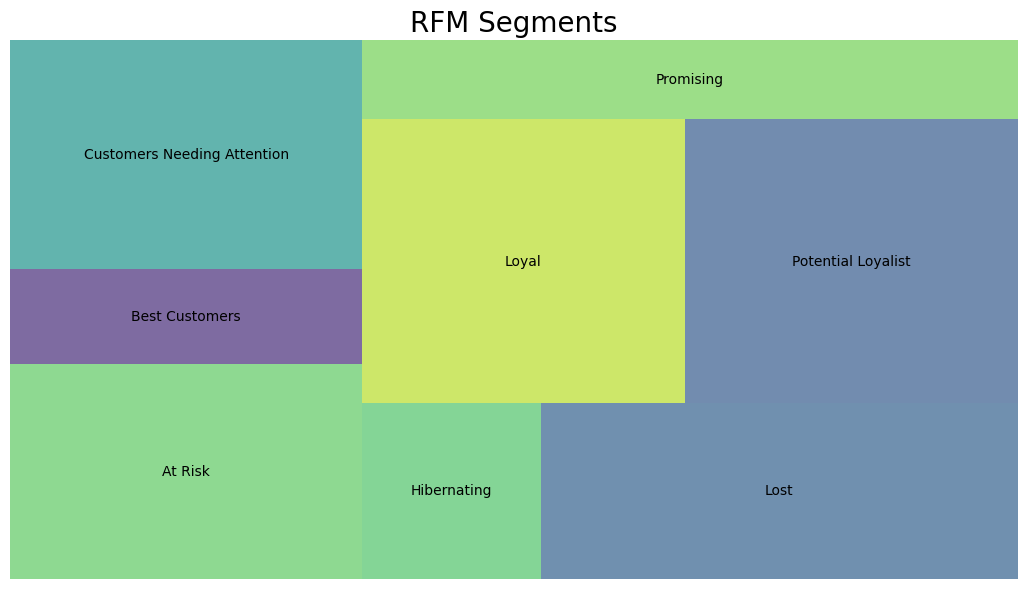

In [ ]:
#RFM visualization
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=rfm_agg['customerid'],
              label=['At Risk',
                     'Best Customers',
                     'Customers Needing Attention',
                     'Hibernating',
                     'Lost',
                     'Loyal',
                     'Potential Loyalist',
                     'Promising'], alpha=0.7)
plt.title("RFM Segments",fontsize=20)
plt.axis('off')
plt.show()


                             customerid  percentage
rfm_level                                          
At Risk                             176   13.924051
Best Customers                       78    6.170886
Customers Needing Attention         188   14.873418
Hibernating                          73    5.775316
Lost                                195   15.427215
Loyal                               213   16.851266
Potential Loyalist                  220   17.405063
Promising                           121    9.572785


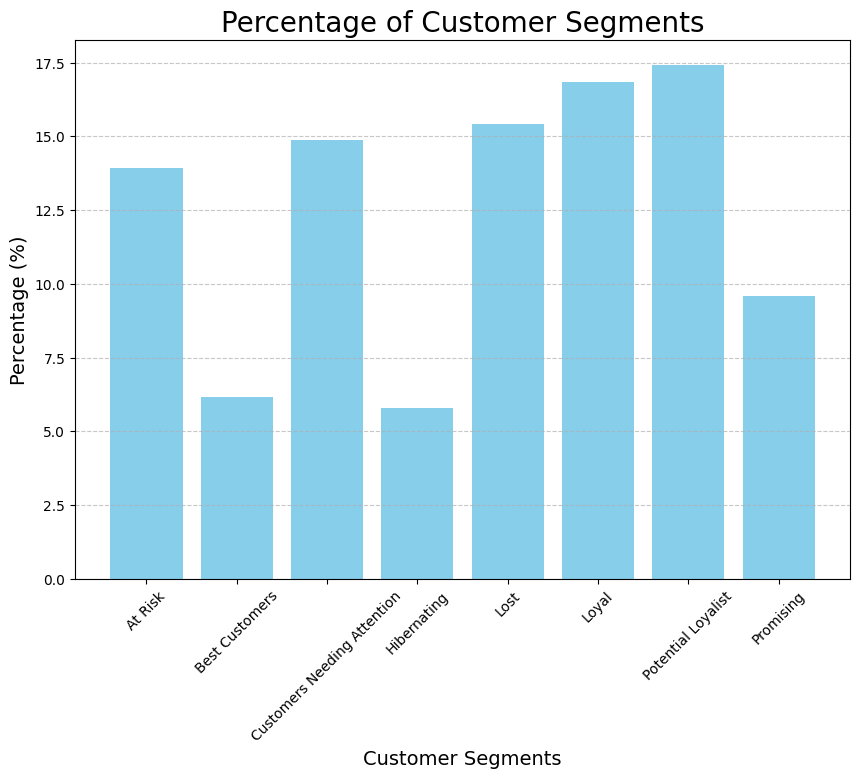

In [ ]:
# Calculate total customers
total_customers = rfm_agg['customerid'].sum()

# Calculate the percentage for each segment
rfm_agg['percentage'] = (rfm_agg['customerid'] / total_customers) * 100

# Print the aggregated DataFrame with percentages
print(rfm_agg)

# Plotting the percentages
plt.figure(figsize=(10, 7))
plt.bar(rfm_agg.index, rfm_agg['percentage'], color='skyblue')
plt.title('Percentage of Customer Segments', fontsize=20)
plt.xlabel('Customer Segments', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
# plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


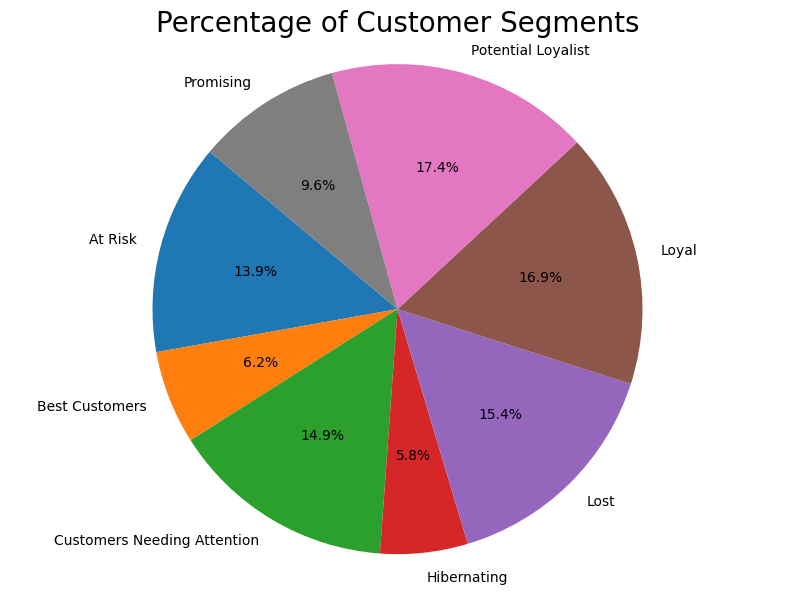

In [ ]:
# Plotting the percentages as a pie chart
plt.figure(figsize=(10, 7))
plt.pie(rfm_agg['percentage'], labels=rfm_agg.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Customer Segments', fontsize=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
